# Using LIA to construct models 

In this notebook, we show how to construct models in LIA. There are 3 steps:
- [Data preparation] Split the dataset in training/testing set. Go over all light-curves and extract the time sampling
- [Training] Train the models
- [Test] Apply the classification on the test data set

## Data preparation

The input data should be computed using `step0_` notebook

In [1]:
from LIA import training_set
from LIA import models
import numpy as np 
from tqdm import tqdm

filename = 'lcs.csv'
lcs = np.loadtxt(filename, dtype=str, delimiter=',')
lcs = lcs[1:]
lcs = lcs[lcs[:,0].astype(float).argsort(),]

split between training and testing dataset

In [2]:
nlcs = len(lcs)
training_data = lcs[:int(3*nlcs/4)]
testing_data = lcs[int(3*nlcs/4):]

# Compute the list of unique light-curve ID
unique_id_train = np.unique(training_data[:,0])
unique_id_test = np.unique(testing_data[:,0])

msg = """
Training: {} light-curves
Testing : {} light-curves
""".format(len(unique_id_train), len(unique_id_test))
print(msg)


Training: 14430 light-curves
Testing : 3589 light-curves



For the training set, retrieve time sampling

In [3]:
unique_filt = np.unique(training_data[:,2])
print('{} light-curves to process ({} bands)...'.format(
    len(unique_id_train), 
    len(unique_filt)
))

# Loop over lightcurve and retrieve time sampling
times = []
for ind in tqdm(unique_id_train):
    for filt in ['1', '2']:
        mask = (training_data[:,0] == ind) & (training_data[:,2] == filt)
        if len(training_data[mask]) > 10:
            light = training_data[mask]
            time = light[:,5].astype(float)

            order = np.argsort(time)
            times.append(time[order])
print('... done')

  0%|          | 0/14430 [00:00<?, ?it/s]

14430 light-curves to process (2 bands)...


100%|██████████| 14430/14430 [11:32<00:00, 19.90it/s]

... done


## Constructing the models

In [4]:
# Train the model - beware time sample and 
# magnitude ranges should be as realistic as possible
training_set.create(times[::1], min_mag=10, max_mag=25, noise=None, n_class=500)

Now simulating variables...
Variables successfully simulated
Now simulating constants...


/Users/julien/anaconda3/lib/python3.7/site-packages/tsfresh-0.14.1-py3.7.egg/tsfresh/feature_extraction/feature_calculators.py:1532: RuntimeWarning: invalid value encountered in true_divide
  similarity_ratio = A / B
/Users/julien/anaconda3/lib/python3.7/site-packages/tsfresh-0.14.1-py3.7.egg/tsfresh/feature_extraction/feature_calculators.py:1533: RuntimeWarning: divide by zero encountered in log
  se = -1 * np.log(similarity_ratio)


Constants successfully simulated
Now simulating CV...
CVs successfully simulated
Now simulating microlensing...
Microlensing events successfully simulated
Writing files...
Saving features...
Computing principal components...
Complete!


In [6]:
rf, pca = models.create_models('all_features.txt', 'pca_features.txt')

# ploting TSNE
# from sklearn.manifold import TSNE as tsne
# import matplotlib.pyplot as plt
# pcapca = np.loadtxt('pca_features.txt',dtype=str)
# vis_data = tsne(n_components=2).fit_transform(pcapca[:,2:].astype(float))
# vis_x = vis_data[:,0]
# vis_y = vis_data[:,1]

# colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'black']
# fig, ax = plt.subplots()
# for i,object_class in enumerate(['Variable', 'Constant', 'CV', 'ML']):
#     x=vis_x[i*n_class:(i+1)*n_class]
#     y=vis_y[i*n_class:(i+1)*n_class]
#     ax.scatter(x, y, c=colors[i], label=object_class)

# plt.legend()
# plt.show()

## Classification

We test the classifier on the test set

In [8]:
import warnings
warnings.filterwarnings('ignore')

from LIA import microlensing_classifier

# Compute the list of unique light-curve ID
print('{} light-curves to process...'.format(len(unique_id_test)))

# Loop over lightcurve and retrieve time samples
times, mags, emags = [], [], []
for ind in tqdm(unique_id_test):
    for filt in ['1', '2']:
        mask = (testing_data[:,0] == ind) & (testing_data[:,2] == filt)
        if len(testing_data[mask]) > 10:
            light = testing_data[mask]
            time = light[:,5].astype(float)
            mag = light[:,-1].astype(float)
            emag = light[:,-2].astype(float)


            order = np.argsort(time)
            times.append(time[order])
            mags.append(mag[order])
            emags.append(emag[order])
print('... done')


classes = []
for i in tqdm(np.arange(0,len(times))[::1]):
    classification,p_ML,p_cons,p_CV,p_var = microlensing_classifier.predict(mags[i], emags[i], rf, pca)
    classes.append([classification,p_ML[0],p_cons[0],p_CV[0],p_var[0]])
classes = np.array(classes)
mask = classes[:,0] == 'ML'
print('Efficiency is {:.1f}%'.format(100*len(classes[mask])/len(classes)))

  0%|          | 3/3589 [00:00<02:20, 25.59it/s]

3589 light-curves to process...


  0%|          | 2/3091 [00:00<03:37, 14.19it/s]

... done


100%|██████████| 3091/3091 [03:33<00:00, 14.46it/s]


Efficiency is 72.75962471692009%


Visual inspection using the confusion matrix

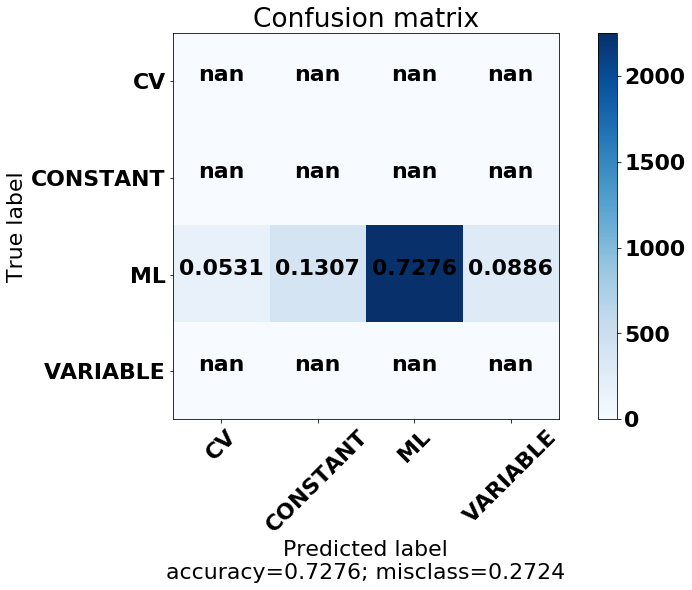

In [11]:
import matplotlib
# Font for plots
font = {
    'weight': 'bold',
    'size': 22
}
matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.manifold import TSNE as tsne
from sklearn.metrics import confusion_matrix


### Stolen confusion matrix
def plot_confusion_matrix(
    cm, target_names, title='Confusion matrix', 
    cmap=None, normalize=True):
    """ given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
conf_mat = confusion_matrix(['ML']*len(times), classes[:,0])
plot_confusion_matrix(conf_mat, ['CV','CONSTANT','ML','VARIABLE'])